In [1]:
import mne
import yasa
import numpy as np
import pandas as pd
import antropy as ant
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.2)

In [2]:
# Load EEG data
f = np.load('data_full_6hrs_100Hz_Cz+Fz+Pz.npz')
data, ch_names = f['data'], f['chan']
data = data.astype(np.float64)
sf = 100.
times = np.arange(data.shape[-1]) / sf
print(data.shape)

(3, 2161058)


In [3]:
# Load the hypnogram data
hypno = np.loadtxt('data_full_6hrs_100Hz_hypno_30s.txt').astype(int)
print(hypno.shape, 'Unique values =', np.unique(hypno))
hypno = yasa.hypno_upsample_to_data(hypno, 1/30, data, sf)

24-Feb-22 14:30:17 | WARNING | Hypnogram is SHORTER than data by 10.58 seconds. Padding hypnogram with last value to match data.size.


(720,) Unique values = [0 1 2 3 4]


******

## Using YASA's function

In [4]:
# Default duration of 5 minutes
decay = yasa.swa_decay(data, hypno=hypno, sf=sf, ch_names=ch_names, include=(2, 3))
decay['Amplitude'] = decay['Intercept'] - decay['Asym']
decay

24-Feb-22 14:30:17 | INFO | 9 NREM epochs longer than 5min were found in hypno.


,Intercept,Asym,Tau,Decay,MAE,Amplitude
Cz,0.857835,0.782926,4.0,0.25,0.053901,0.074909
Fz,0.860006,0.797218,4.0,0.25,0.052746,0.062788
Pz,0.848753,0.781713,4.0,0.25,0.060630,0.067040


In [5]:
# 10 minutes
yasa.swa_decay(
    data, hypno=hypno, sf=sf, 
    ch_names=ch_names, epoch_length="10min", include=(2, 3))

24-Feb-22 14:30:18 | INFO | 6 NREM epochs longer than 10min were found in hypno.


,Intercept,Asym,Tau,Decay,MAE
Cz,0.942651,0.749949,4.0,0.25,0.050078
Fz,0.950083,0.757681,4.0,0.25,0.045963
Pz,0.945624,0.744350,4.0,0.25,0.054237


In [6]:
# 2 minutes
yasa.swa_decay(
    data, hypno=hypno, sf=sf, 
    ch_names=ch_names, epoch_length="2min", include=(2, 3))

24-Feb-22 14:30:19 | INFO | 11 NREM epochs longer than 2min were found in hypno.


,Intercept,Asym,Tau,Decay,MAE
Cz,0.854899,0.776405,4.0,0.25,0.046404
Fz,0.854580,0.789373,4.0,0.25,0.046589
Pz,0.845419,0.775258,4.0,0.25,0.052036


*******

## Step-by-step

In [7]:
# Bandpass filter
data = mne.filter.filter_data(data.astype('float64'), sf, 0.5, 30, verbose=0)

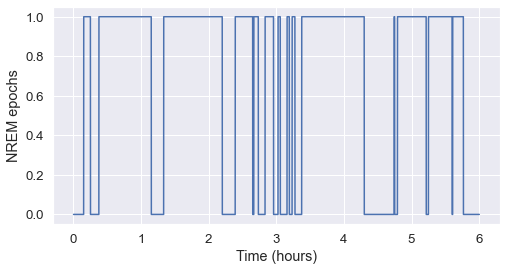

In [8]:
include = (2, 3)
mask = np.in1d(hypno, include).astype(int)

plt.figure(figsize=(8, 4))
plt.plot(times / 3600, mask);
plt.xlabel("Time (hours)")
plt.ylabel("NREM epochs");

In [9]:
# Sleep onset is defined as the first epoch of N2 or N3 sleep
idx_onset = np.nonzero(np.in1d(hypno, (2, 3)))[0][0]

In [10]:
def find_runs(x):
    """Find runs of consecutive items in an array.

    From https://gist.github.com/alimanfoo/c5977e87111abe8127453b21204c1065
    """
    n = x.shape[0]
    # Find run starts
    loc_run_start = np.empty(n, dtype=bool)
    loc_run_start[0] = True
    np.not_equal(x[:-1], x[1:], out=loc_run_start[1:])
    run_starts = np.nonzero(loc_run_start)[0]
    # Find run values
    run_values = x[loc_run_start]
    # Find run lengths
    run_lengths = np.diff(np.append(run_starts, n))
    return pd.DataFrame({'values': run_values, 'start': run_starts, 'length': run_lengths})

In [11]:
# Calculate NREM periods
n_samples_thr = int(pd.Timedelta("10min").seconds * sf)

# This show the onset and duration (in samples) of all the NREM epochs
epochs = find_runs(mask).query("values == 1 and length > @n_samples_thr").reset_index(drop=True)
epochs

,values,start,length
0,1,135000,279000
1,1,480000,312000
2,1,861000,93000
3,1,1215000,333000
4,1,1725000,153000
5,1,1890000,126000


In [12]:
# Method 2: equal length window
# n_windows = int(np.floor(mask[idx_onset:].size / n_samples_thr))
# epoch_counter = 0

# epochs = {'values': [], 'start': [], 'length': []}

# for i in range(n_windows):
#     start = idx_onset + n_samples_thr * i
#     end = start + n_samples_thr
#     if mask[start:end].all():
#         epochs['values'].append(1)
#         epochs['start'].append(start)
#         epochs['length'].append(end - start)
        
# epochs = pd.DataFrame(epochs)
# epochs

In [13]:
# Calculate the onset time (relative to sleep onset) of each NREM period
epochs['time_onset_hrs'] = (epochs['start'] - idx_onset) / sf / 3600
epochs['length_hrs'] = epochs['length'] / 2 / sf / 3600
epochs['time_mid_hrs'] = epochs['time_onset_hrs'] + epochs['length_hrs']
epochs

,values,start,length,time_onset_hrs,length_hrs,time_mid_hrs
0,1,135000,279000,0.225000,0.387500,0.612500
1,1,480000,312000,1.183333,0.433333,1.616667
2,1,861000,93000,2.241667,0.129167,2.370833
3,1,1215000,333000,3.225000,0.462500,3.687500
4,1,1725000,153000,4.641667,0.212500,4.854167
5,1,1890000,126000,5.100000,0.175000,5.275000


In [14]:
# Calculate continuous mask with unique value for each epoch
mask_epoch = np.zeros_like(mask, dtype=int)
for i, row in epochs.iterrows():
    start = int(row['start'])
    end = int(row['start']+row['length'])
    mask_epoch[start:end] = i + 1

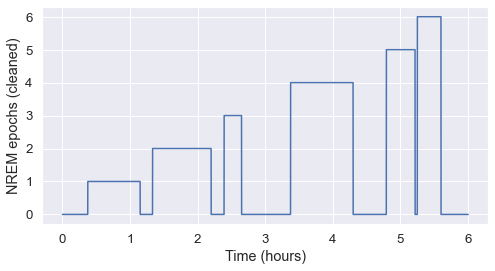

In [15]:
plt.figure(figsize=(8, 4))
plt.plot(times / 3600, mask_epoch);
plt.xlabel("Time (hours)")
plt.ylabel("NREM epochs (cleaned)");

In [16]:
# Calculate SWA power in each period, for each channel
nperseg = int(4 * sf)
freq_swa = (0.5, 4)
freq_broad = (0.5, 30)
win_sec = 4
kwargs_welch = dict(average='median', window='hamming')

bp = yasa.bandpower(
    data, sf, ch_names=ch_names, hypno=mask_epoch, include=list(range(1, max(mask_epoch) + 1)), 
    win_sec=win_sec, relative=True, bandpass=False, 
    bands=[(freq_swa[0], freq_swa[1], "SWA"), (freq_broad[0], freq_broad[1], "Broad")], 
    kwargs_welch=kwargs_welch)

bp

SWA  Broad  TotalAbsPow  FreqRes  Relative
Stage Chan                                                 
1     Cz    0.879990    1.0   759.297013     0.25      True
      Fz    0.891554    1.0   679.378981     0.25      True
      Pz    0.881084    1.0   649.507425     0.25      True
2     Cz    0.932772    1.0  1258.679770     0.25      True
      Fz    0.935314    1.0  1077.608011     0.25      True
      Pz    0.937276    1.0  1160.018559     0.25      True
3     Cz    0.813878    1.0   300.108848     0.25      True
      Fz    0.822825    1.0   238.431764     0.25      True
      Pz    0.805654    1.0   271.955867     0.25      True
4     Cz    0.922646    1.0  1005.541157     0.25      True
      Fz    0.922905    1.0   811.771503     0.25      True
      Pz    0.928555    1.0   982.958838     0.25      True
5     Cz    0.767149    1.0   211.257012     0.25      True
      Fz    0.779665    1.0   162.488099     0.25      True
      Pz    0.753458    1.0   202.490184     0.25      True
6     Cz    0.769222    1.0   279.616880     0.25      True
      Fz    0.778872    1.0   203.675059     0.25      True
      Pz    0.772102    1.0   253.092206     0.25      True

In [17]:
# Calculate exponential decline
# https://doi.org/10.1093/sleep/33.4.491
# https://bmcneurosci.biomedcentral.com/articles/10.1186/1471-2202-12-84#Sec8
# S(t) = (S_sleeponset - lower_asym) * exp(-t / slope) + lower_asym
# - The time t starts at zero at sleep onset.
# - Data were normalized within each subject with mean SWA across all derivations
# - Therefore, SWA and LA are expressed in percentage.
# Thus, τd was restricted to a range of 0 to 4 h. Additionally, LA was forced to be larger or equal zero.
from scipy.optimize import curve_fit

def _decay_func(t, asym, intercept, tau):
    """Exponential decay equation"""
    return (intercept - asym) * np.exp(- t / tau) + asym
    # return (intercept - asym) * np.exp(- slope * t) + asym

xdata = epochs['time_mid_hrs'].to_numpy()
ydata = bp.xs(ch_names[1], level=-1)["SWA"]

# Asymptote must be between 0 and 1 if evaluating relative power
# Intercept must be between 0 and 1 if evaluating relative power
# Slope must be between 

popt, _ = curve_fit(_decay_func, xdata, ydata, p0=(0.5, 0.8, 1),
                    bounds=((0, 0, 0), (1, 1, 4)), method="trf")

mse = np.mean((ydata - _decay_func(xdata, *popt))**2)

print(np.round(popt, 3), "- MSE =", round(mse, 3))

[0.758 0.95  4.   ] - MSE = 0.003


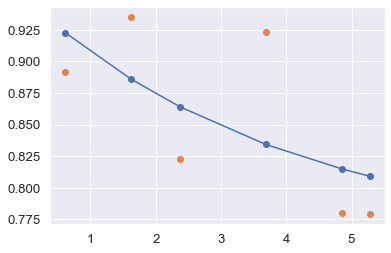

In [18]:
plt.plot(xdata, _decay_func(xdata, *popt), marker="o");
plt.plot(xdata, ydata, linewidth=0, marker="o");

*******

### Simulation

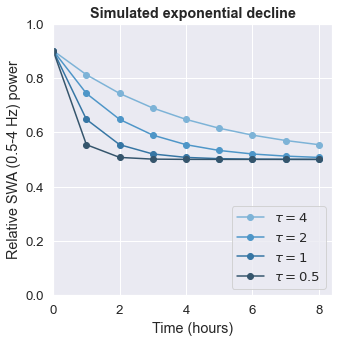

In [19]:
sim_xdata = np.arange(0, 9, 1)
pal = sns.color_palette("Blues_d", n_colors=4)

plt.figure(figsize=(5, 5))
plt.plot(sim_xdata, _decay_func(sim_xdata, *[0.5, 0.9, 4]), 
         marker="o", color=pal[0], label="$\\tau = 4$");
plt.plot(sim_xdata, _decay_func(sim_xdata, *[0.5, 0.9, 2]), 
         marker="o", color=pal[1], label="$\\tau = 2$");
plt.plot(sim_xdata, _decay_func(sim_xdata, *[0.5, 0.9, 1]), 
         marker="o", color=pal[2], label="$\\tau = 1$");
plt.plot(sim_xdata, _decay_func(sim_xdata, *[0.5, 0.9, 0.5]), 
         marker="o", color=pal[3], label="$\\tau = 0.5$");
plt.ylim(0, 1)
plt.xlim(0, None)
plt.xlabel("Time (hours)")
plt.ylabel("Relative SWA (0.5-4 Hz) power")
plt.title("Simulated exponential decline", fontweight="bold")
plt.legend(frameon=True, loc="lower right");